# Notebook to finetune Finnish Version of BERT (https://github.com/TurkuNLP/FinBERT)

# Using datafrom: https://github.com/aajanki/eduskunta-vkk

In [8]:
#Data
import pandas as pd

train_df = pd.read_csv("data/train.csv")
label_names = train_df.ministry.unique()

classnames = {}
for i, label in enumerate(label_names):
    classnames[label] = i
    
def labelfromclass(classname):
    return classnames[classname]

def classfromlabel(label):
    keys = list(classnames.keys())
    values = list(classnames.values())
    return keys[values.index(label)]

print(label_names)

['sisäministeri' 'oikeus- ja työministeri'
 'maatalous- ja ympäristöministeri' 'perhe- ja peruspalveluministeri'
 'sosiaali- ja terveysministeri' 'opetus- ja kulttuuriministeri'
 'eurooppa-, kulttuuri- ja urheiluministeri'
 'liikenne- ja viestintäministeri' 'ulkoministeri' 'pääministeri'
 'valtiovarainministeri' 'elinkeinoministeri'
 'kunta- ja uudistusministeri' 'puolustusministeri'
 'ulkomaankauppa- ja kehitysministeri']


In [9]:
train_df.head(10)

,sentence,ministry
0,Hallituksen esityksen 43/2016vp valmistelussa ...,sisäministeri
1,Suojaosuuden nostaminen vähentäisi kaikkien ve...,oikeus- ja työministeri
2,Edistämällä puun käyttöä rakentamisessa tuetaa...,maatalous- ja ympäristöministeri
3,Valvira ja aluehallintovirastot ovat ottaneet ...,perhe- ja peruspalveluministeri
4,Lainmuutoksessa säädettiin vaativan lääkinnäll...,sosiaali- ja terveysministeri
5,"Hilan tehtävänä on siis päättää , mitkä lääkke...",sosiaali- ja terveysministeri
6,Ammattikorkeakoulujen opiskelijakunnista sääde...,opetus- ja kulttuuriministeri
7,"Kysymyksessäkin todetusti on tärkeää , että ty...",sosiaali- ja terveysministeri
8,Laki ei sinällään sisällä sanktioita työntekij...,perhe- ja peruspalveluministeri
9,Sibeliuksen syntymäpäivän 8.12. ja Eurooppa-pä...,sisäministeri


tensor([0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0004, 0.0005,
        0.0011, 0.0011, 0.0013, 0.0013, 0.0013, 0.0016])


<AxesSubplot:>

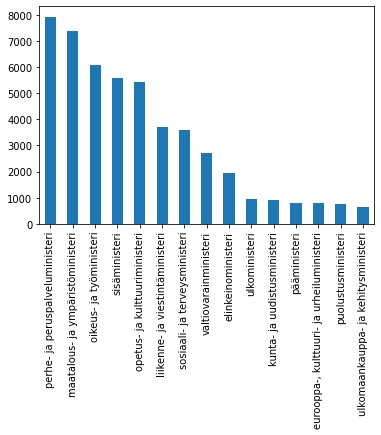

In [23]:
#Count of different classes
#Very uneven distribution of classes
import seaborn as sns
label_counts = train_df.ministry.value_counts()
label_counts = [label_counts[i] for i in range(len(label_counts))]

#class weights to counter class imbalance
class_weights = 1./(torch.tensor(label_counts))
print(class_weights)

train_df.ministry.value_counts().plot(kind='bar')

In [21]:
from torch.utils.data import Dataset, DataLoader
import torch
import transformers

tokenizer = transformers.BertTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-uncased-v1")

class TextClassificationDataset(Dataset):
    """
    Dataset class for textclassification
    Tokenization handled in dataloader
    """
    def __init__(self, datafile):
        
        try:
            self.dataframe = pd.read_csv(datafile)
        except:
            print(f"opening file:{datafile} failed")
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        sentence = row['sentence']
        label = labelfromclass(row['ministry'])
        return sentence, label
            

def collate_func(batch):
    """
    collate function handles tokenization and attention mask
    """
    sents, labels = zip(*batch)
    encoding = tokenizer(list(sents), return_tensors='pt', padding=True, truncation=True ,max_length=256)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    return (input_ids, attention_mask, torch.tensor(labels).unsqueeze(0)) 

   
trainset = TextClassificationDataset("data/train.csv")
evalset = TextClassificationDataset("data/dev.csv")
dataloader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_func)

In [22]:
import numpy as np


def get_accuracy(logits, labels):
    predictions = torch.max(logits, dim=1)[1]
    return (predictions==labels.squeeze(-1)).sum().item()


@torch.no_grad()
def evaluation_stats(model, evalloader):
    """
    returns accucary and mean loss on evaluation set
    """
    accuracy = 0
    num_sents = 0
    losses = []
    model.eval()
    for data in evalloader:
        
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        losses.append(outputs.loss.item())
        accuracy+=get_accuracy(outputs.logits, labels)
        num_sents+=outputs.logits.shape[0]
        
    print(accuracy)
    return (sum(losses)/len(losses), float(accuracy)/float(num_sents))

@torch.no_grad()
def get_preds(model, dataloader):
    predictions = []
    real_labels = []
    model.eval()
    for data in dataloader:
        
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        preds = torch.max(outputs.logits, dim=1)[1]
        predictions.append(preds.unsqueeze(1).cpu().detach())
        real_labels.append(labels.cpu().detach().T)
        
    return torch.cat(predictions).numpy(), torch.cat(real_labels).numpy()
            
        

#evaluation_stats(model, evalloader)
#preds, labels = get_preds(model, evalloader)

In [61]:
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

#Parameters
epochs = 6
BATCH_SIZE = 64
LR=2e-5
device = 'cuda'
save_checkpoint = True
use_class_weights = False
use_optimizer_grouped_parameters = True
use_linear_schedule = True
clip_grad = None

print("initializing model")
model = BertForSequenceClassification.from_pretrained("TurkuNLP/bert-base-finnish-uncased-v1", num_labels=len(label_names))
model.to(device)

print("initializing datasets and optimizer")
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=collate_func)
evalloader = DataLoader(evalset, batch_size=BATCH_SIZE, collate_fn=collate_func)

#Optimizer
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

if use_optimizer_grouped_parameters:
    optimizer=AdamW(optimizer_grouped_parameters, lr=LR)

if not use_optimizer_grouped_parameters:
    optimizer = AdamW(model.parameters(), lr=LR)

    

if use_linear_schedule:
    num_train_steps = len(trainloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
    

#Loss function
class_weights = class_weights.to(device)
if use_class_weights:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
if not use_class_weights:
    criterion = nn.CrossEntropyLoss()

eval_stats_list = []

#print evaluation stats before any training
eval_stats = evaluation_stats(model, evalloader)
eval_stats_list.append(eval_stats)
best_acc = 0

print(eval_stats)


print("starting training")
for epoch in range(epochs):
    print(f"starting epoch:{epoch+1}")
    i=0
    losses = []
    model.train()
    for data in tqdm(trainloader):
        i+=1
        
        optimizer.zero_grad()
        
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(inputs, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels.squeeze(0))
        loss.backward()
        
        if clip_grad!=None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        
        optimizer.step()
        if use_linear_schedule:
            scheduler.step()
        losses.append(loss.item())
        
    print(f"Training Loss Epoch{epoch+1}: {sum(losses)/len(losses)}")
    eval_stats = evaluation_stats(model, evalloader)
    if eval_stats[1] > best_acc:
        best_acc = eval_stats[1]
        if save_checkpoint:
            torch.save(model.state_dict(), "bestmodel.pt")
    print(eval_stats)
    eval_stats_list.append(eval_stats)
    
#for data in evalloader

initializing model


Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

initializing datasets and optimizer
344
(2.7175044455426804, 0.11466666666666667)
starting training
starting epoch:1


  0%|          | 0/768 [00:00<?, ?it/s]

Training Loss Epoch1: 1.1431246136004727
2203
(0.8530740256005145, 0.7343333333333333)
starting epoch:2


  0%|          | 0/768 [00:00<?, ?it/s]

Training Loss Epoch2: 0.754994900431484
2266
(0.7833820042457986, 0.7553333333333333)
starting epoch:3


  0%|          | 0/768 [00:00<?, ?it/s]

Training Loss Epoch3: 0.5712252810869055
2294
(0.7686967494639945, 0.7646666666666667)
starting epoch:4


  0%|          | 0/768 [00:00<?, ?it/s]

Training Loss Epoch4: 0.43615720329883817
2305
(0.7759229414006497, 0.7683333333333333)
starting epoch:5


  0%|          | 0/768 [00:00<?, ?it/s]

Training Loss Epoch5: 0.3403503564283407
2316
(0.7937957327416603, 0.772)
starting epoch:6


  0%|          | 0/768 [00:00<?, ?it/s]

Training Loss Epoch6: 0.28510242891691934
2331
(0.8026553069023376, 0.777)


In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
testset = TextClassificationDataset("data/test.csv")
testloader = DataLoader(testset, batch_size=BATCH_SIZE, collate_fn=collate_func)
preds, labels = get_preds(model, testloader)
val_preds, val_labels = get_preds(model, evalloader)
print(f"test accuracy:{np.mean(preds==labels)}")
print(f"validation accuracy:{np.mean(val_preds==val_labels)}")

test accuracy:0.7603333333333333
validation accuracy:0.777


In [67]:
print("Test statistics:")
print(classification_report(labels, preds, target_names=label_names))

Test statistics:
                                           precision    recall  f1-score   support

                            sisäministeri       0.76      0.76      0.76       336
                  oikeus- ja työministeri       0.67      0.73      0.70       362
         maatalous- ja ympäristöministeri       0.84      0.85      0.85       450
          perhe- ja peruspalveluministeri       0.77      0.79      0.78       480
            sosiaali- ja terveysministeri       0.69      0.66      0.67       215
            opetus- ja kulttuuriministeri       0.85      0.83      0.84       348
eurooppa-, kulttuuri- ja urheiluministeri       0.70      0.59      0.64        51
          liikenne- ja viestintäministeri       0.79      0.81      0.80       231
                            ulkoministeri       0.77      0.74      0.75        76
                             pääministeri       0.59      0.50      0.54        54
                    valtiovarainministeri       0.77      0.74      0

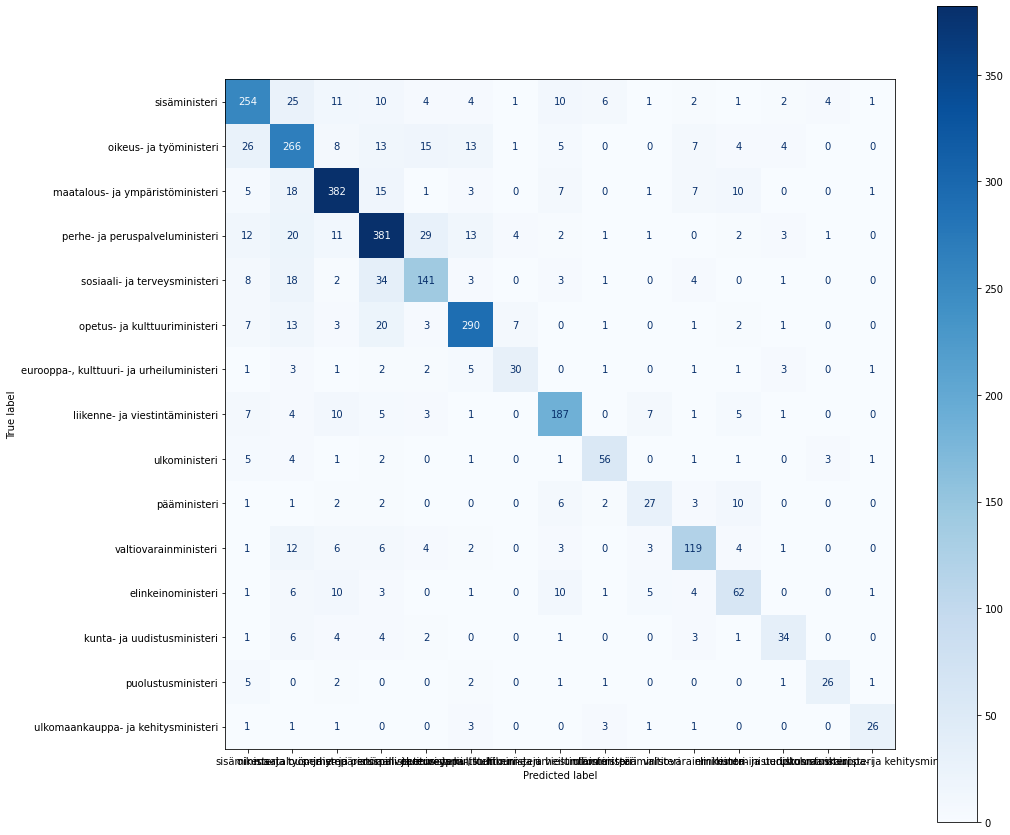

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Things to add:

1. Quantization of model
2. prioritized sampling